In [4]:
from keras.datasets import mnist 
from keras.models import Model 
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import tensorflow.compat.v1.keras.backend as K 
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
from pathlib import Path
import numpy as np

In [5]:
results_dir = Path('results').joinpath('vae') 
results_dir.mkdir(parents=True, exist_ok=True)

In [7]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img) 
x = layers.Conv2D(64, 3,
padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x) 
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x) 
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [9]:
z= layers.Lambda(sampling)([z_mean, z_log_var]) 
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same',activation='sigmoid')(x) 
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [10]:
class CustomVariationalLayer(keras.layers.Layer): 
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def call(self, inputs): 
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded) 
        self.add_loss(loss, inputs=inputs) 
        return x

In [11]:
y= CustomVariationalLayer()([input_img, z_decoded])

In [12]:
vae= Model(input_img, y) 
vae.compile(optimizer='rmsprop', loss=None) 
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [13]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

11493376/11490434 [==============================] - 2s 0us/step


In [14]:
vae.fit(x=x_train, y=None,shuffle=True,epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 6619566.5681 - val_loss: 0.1986
Epoch 2/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1936 - val_loss: 0.1960
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1888 - val_loss: 0.1867
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1861 - val_loss: 0.1873
Epoch 5/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1843 - val_loss: 0.1837
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1831 - val_loss: 0.1822
Epoch 7/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1820 - val_loss: 0.1807
Epoch 8/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1811 - val_loss: 0.1800
Epoch 9/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1804 

In [15]:
import matplotlib.pyplot as plt 
from scipy.stats import norm

In [16]:
n = 15
digit_size = 28
figure= np.zeros((digit_size * n, digit_size * n)) 
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [17]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2) 
        x_decoded = decoder.predict(z_sample, batch_size=batch_size) 
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

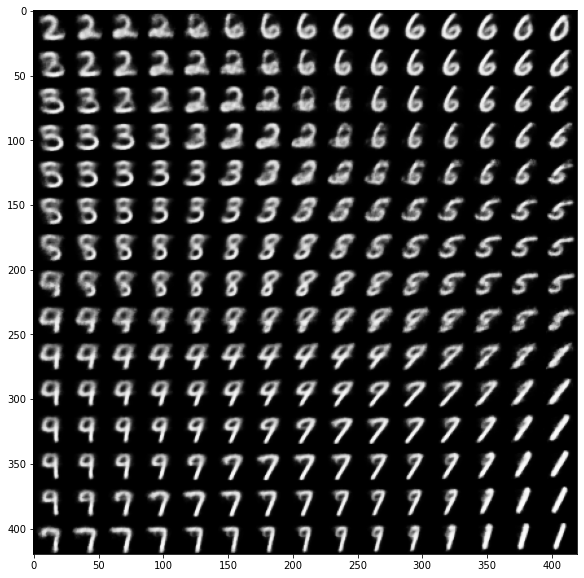

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
img_file = results_dir.joinpath('\Downloads\assignment 12') 
plt.savefig(img_file)
plt.show()